In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [4]:
YEARS = range(1999, 2025)

In [ ]:
'''
data_list = []

for i in YEARS:  
    i_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(i) + '.csv.gz',
                   compression= 'gzip', low_memory= False)
    i_data['year'] = i
    data_list.append(i_data)

data = pd.concat(data_list, ignore_index=True, sort=True)

data.to_pickle('../data/nfl_pbp_data.pkl')
data.to_csv('../data/nfl_pbp_data.csv')
'''

data = pd.read_pickle('../data/nfl_pbp_data.pkl')

In [35]:
data

,aborted_play,air_epa,air_wpa,air_yards,assist_tackle,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,...,xyac_success,yac_epa,yac_wpa,yardline_100,yards_after_catch,yards_gained,ydsnet,ydstogo,year,yrdln
0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,NaN,0.0,6.0,0,1999,ARI 30
1,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,NaN,0.0,6.0,10,1999,PHI 23
2,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,NaN,1.0,6.0,10,1999,PHI 23
3,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,76.0,NaN,0.0,6.0,9,1999,PHI 24
4,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,81.0,NaN,10.0,6.0,14,1999,PHI 19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230674,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,64.0,NaN,1.0,7.0,4,2024,WAS 36
1230675,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,63.0,NaN,0.0,7.0,3,2024,WAS 37
1230676,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.0,NaN,-2.0,-3.0,10,2024,WAS 37
1230677,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,39.0,NaN,-1.0,-3.0,12,2024,WAS 39


In [8]:
def passer_rating(cmp, pass_yds, tds, ints, att):
    a = (cmp/att - .3) * 5
    b = (pass_yds/att - 3) * .25
    c = (tds/att) * 20
    d = 2.375 - (25 * ints/att)

    return ((a+b+c+d)/6) * 100

def anya(pass_yds, tds, ints, sack_yds, sacks, pass_attempts):
    return (pass_yds + (tds * 20) - (ints * 45) - sack_yds)/(pass_attempts + sacks)

In [58]:
#decided to focus on passer rating, ANY/A and EPA as stats.



data['sack_yards'] = np.where(data['sack'] == 1, data['yards_gained'], 0)
game_data = data.groupby(['game_id', 'passer_player_name']).agg({'air_yards' : 'sum', 
                                                                 'yards_after_catch' : 'sum',
                                                                 'yards_gained' : 'sum',
                                                                 'sack_yards' : 'sum',
                                                                 'touchdown' : 'sum',
                                                                 'complete_pass' : 'sum', 
                                                                 'interception' : 'sum', 
                                                                 'pass_attempt' : 'sum', 
                                                                 'sack' : 'sum',
                                                                 'qb_epa' : 'mean',
                                                                 'home_team': 'first',
                                                                 'away_team': 'first'}).reset_index()
sack_data = data[data['sack']==1]
#sack_data

game_data['any/a'] = game_data.apply(lambda row: anya(pass_yds=row['air_yards'], tds=row['touchdown'], ints=row['interception'], sack_yds=row['sack_yards'], sacks=row['sack'], pass_attempts=row['pass_attempt']), axis = 1)
game_data['passer_rating'] = game_data.apply(lambda row: passer_rating(cmp = row['complete_pass'], pass_yds = row['air_yards'], tds = row['touchdown'], ints = row['interception'], att = row['pass_attempt']), axis = 1)

(array([2.000e+00, 3.000e+00, 2.000e+01, 1.590e+02, 1.249e+03, 5.327e+03,
        6.011e+03, 1.592e+03, 1.760e+02, 1.200e+01]),
 array([-2.37098798, -1.97468304, -1.5783781 , -1.18207316, -0.78576822,
        -0.38946328,  0.00684166,  0.4031466 ,  0.79945154,  1.19575648,
         1.59206142]),
 <BarContainer object of 10 artists>)

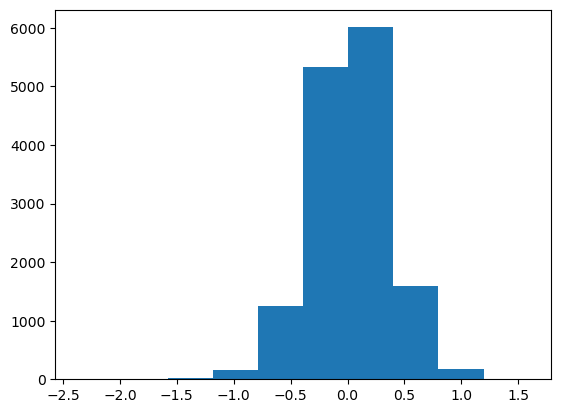

In [59]:
qb_game_data = game_data[game_data['pass_attempt'] > 10]
plt.hist(qb_game_data['qb_epa'])

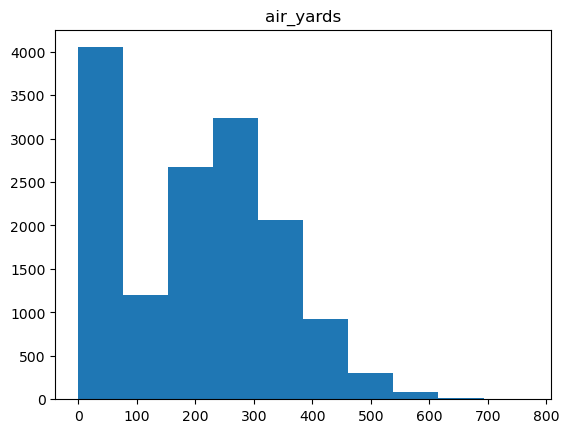

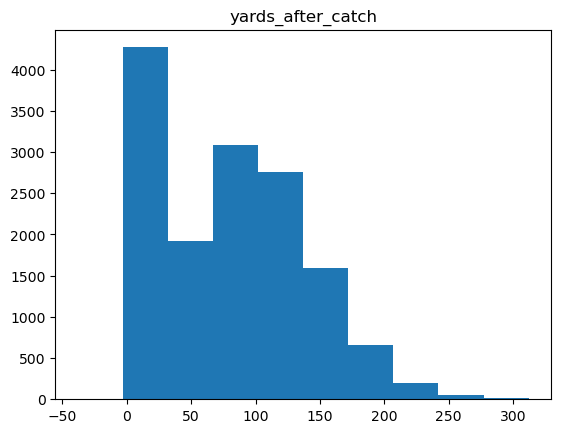

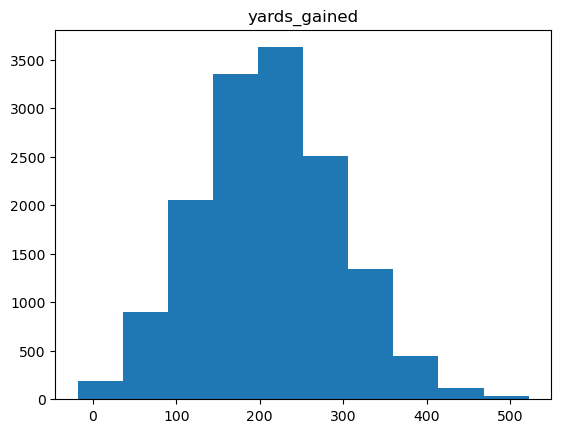

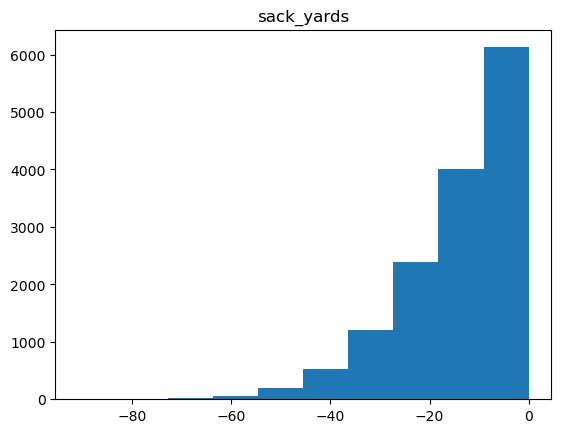

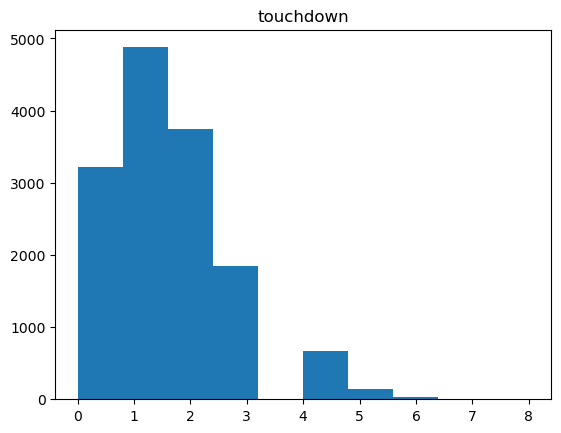

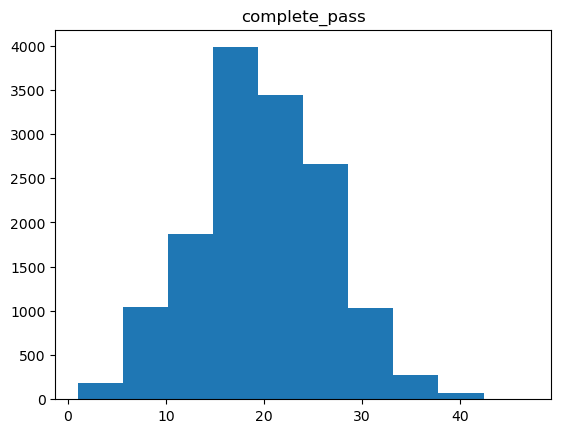

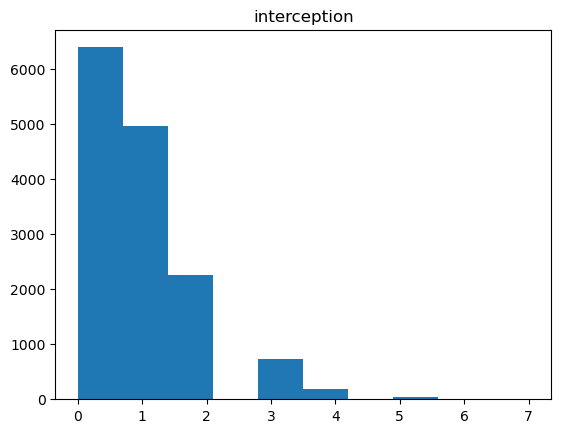

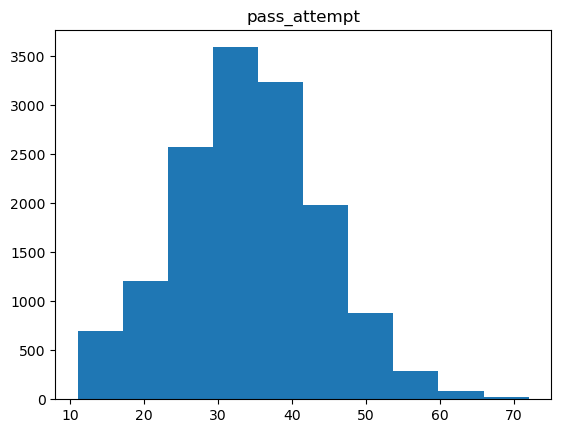

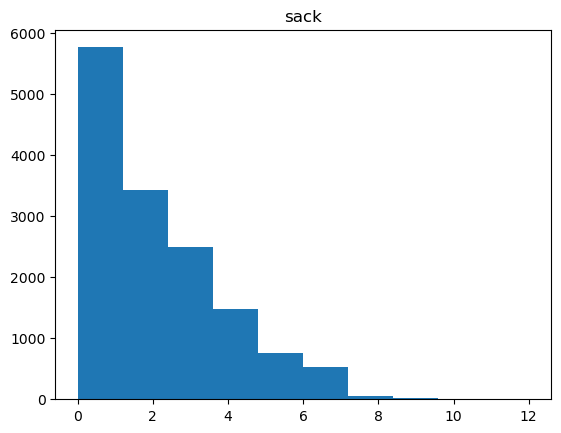

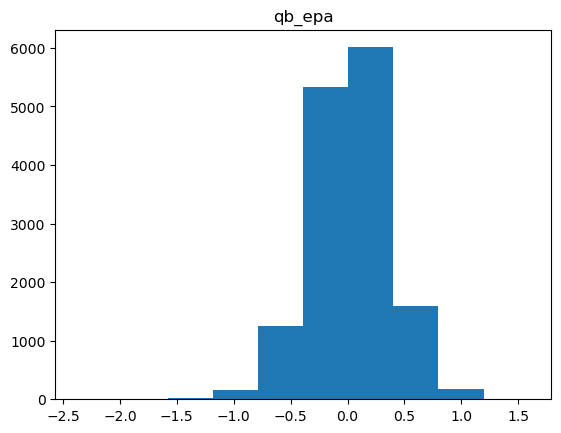

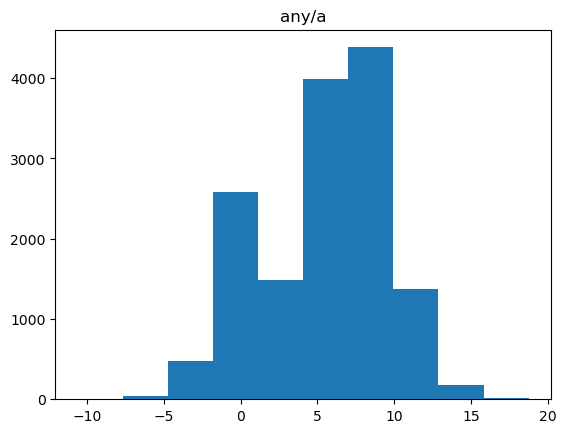

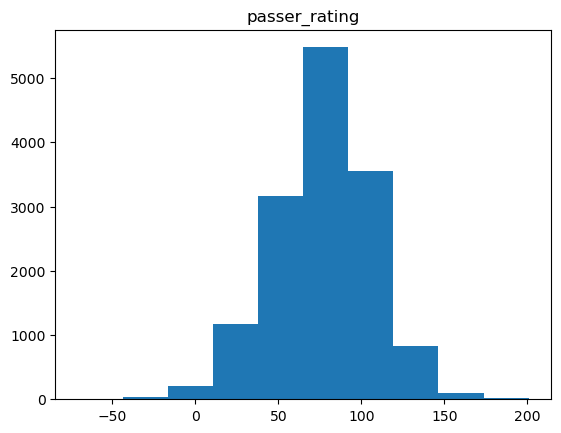

In [14]:
qb_game_columns = qb_game_data.columns.to_list()
for col in qb_game_columns:
    if pd.api.types.is_numeric_dtype(qb_game_data[col]):
        plt.hist(qb_game_data[col])
        plt.title(col)
        plt.show();

In [61]:
purdy_data = qb_game_data[qb_game_data['passer_player_name']=='B.Purdy']
garoppolo_data = qb_game_data[(qb_game_data['passer_player_name']=='J.Garoppolo') & ((qb_game_data['home_team'] == 'SF') | (qb_game_data['away_team'] == 'SF'))]

# top ten QB APY for 2024 accoridng to https://overthecap.com/position/quarterback
ten_highest_paid_qbs = ['D.Prescott', 'J.Burrow', 'J.Love', 'T.Lawrence', 'T.Tagovailoa', 'J.Goff', 'J.Herbert', 'L.Jackson', 'J.Hurts', 'K.Murray']
top_ten_data = qb_game_data[qb_game_data['passer_player_name'].isin(ten_highest_paid_qbs)]

top_ten_data

,game_id,passer_player_name,air_yards,yards_after_catch,yards_gained,sack_yards,touchdown,complete_pass,interception,pass_attempt,sack,qb_epa,home_team,away_team,any/a,passer_rating
11175,2016_01_NYG_DAL,D.Prescott,406.0,76.0,227.0,0.0,0.0,25.0,0.0,45.0,0.0,0.033627,DAL,NYG,9.022222,85.972222
11191,2016_02_DAL_WAS,D.Prescott,191.0,157.0,278.0,-14.0,0.0,22.0,0.0,34.0,4.0,0.468884,WAS,DAL,5.394737,79.411765
11229,2016_03_CHI_DAL,D.Prescott,217.0,93.0,248.0,0.0,1.0,19.0,0.0,24.0,0.0,0.624075,DAL,CHI,9.875000,119.618056
11266,2016_04_DAL_SF,D.Prescott,179.0,129.0,234.0,-11.0,2.0,23.0,0.0,34.0,2.0,0.325480,SF,DAL,6.388889,100.000000
11300,2016_05_CIN_DAL,D.Prescott,150.0,104.0,222.0,-5.0,1.0,18.0,0.0,25.0,1.0,0.395393,DAL,CIN,6.730769,100.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17219,2024_19_PIT_BAL,L.Jackson,118.0,86.0,165.0,-10.0,2.0,16.0,0.0,22.0,1.0,0.429398,BAL,PIT,7.304348,115.340909
17224,2024_20_BAL_BUF,L.Jackson,260.0,85.0,240.0,-14.0,2.0,18.0,1.0,29.0,2.0,0.157386,BUF,BAL,8.677419,99.784483
17227,2024_20_LA_PHI,J.Hurts,129.0,86.0,65.0,-63.0,0.0,15.0,0.0,27.0,7.0,-0.176478,PHI,LA,5.647059,68.287037
17231,2024_20_WAS_DET,J.Goff,331.0,153.0,297.0,-16.0,2.0,23.0,3.0,42.0,2.0,-0.105712,DET,WAS,5.727273,66.666667


In [62]:
def plot_qb_purdy_ten(qb_df=qb_game_data, purdy_df=purdy_data, top_ten_df=top_ten_data, x_label='air_yards', y_label='passer_rating', include_garopollo = False):
    plt.scatter(x=qb_df[x_label], y=qb_df[y_label], color = 'gray', alpha=.5, label='All other QBs')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.scatter(x=top_ten_df[x_label], y=top_ten_df[y_label], color = 'green', alpha=.5, label='Top 10 Highest Paid QBs')
    plt.scatter(x=purdy_df[x_label], y=purdy_df[y_label], color = 'red', alpha=.7, label='Purdy')
    if include_garopollo:
        plt.scatter(x=garoppolo_data[x_label], y=garoppolo_data[y_label], color = 'orange', alpha=.7, label='Garopollo with the 49ers')
    plt.legend()
    plt.show();

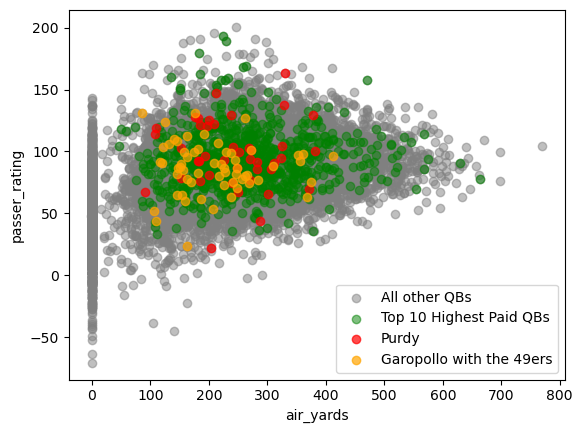

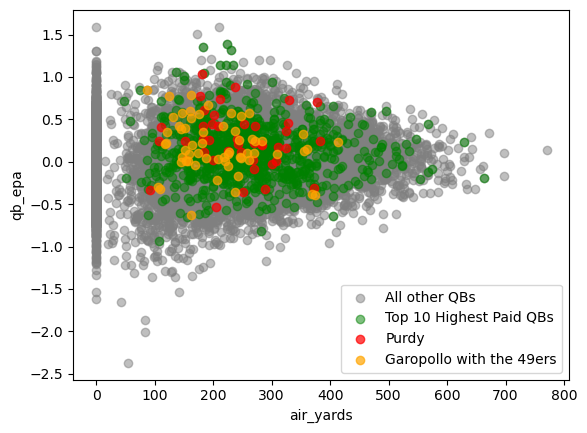

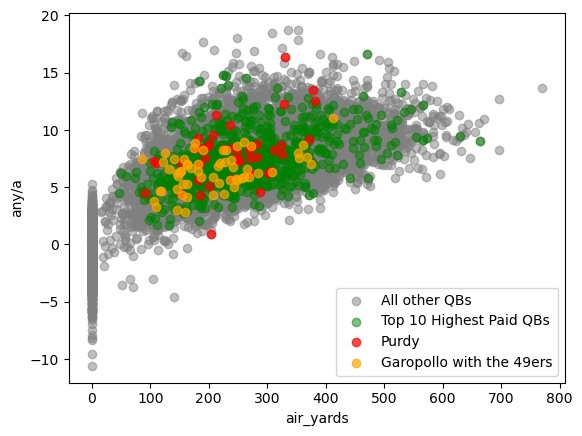

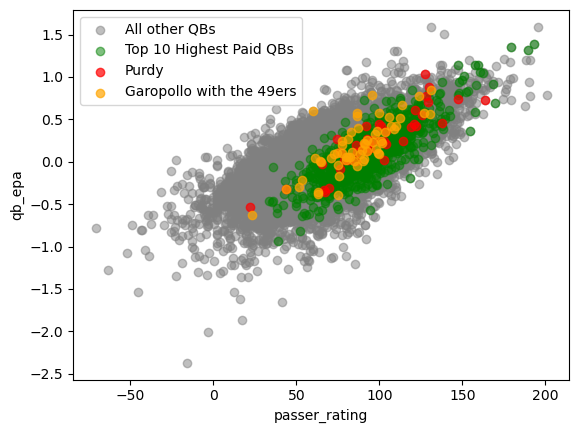

In [63]:
plot_qb_purdy_ten(x_label='air_yards', y_label='passer_rating', include_garopollo=True)

plot_qb_purdy_ten(x_label='air_yards', y_label='qb_epa', include_garopollo=True)

plot_qb_purdy_ten(x_label='air_yards', y_label='any/a', include_garopollo=True)

plot_qb_purdy_ten(x_label='passer_rating', y_label='qb_epa', include_garopollo=True)

In [74]:
def compare_stat(qb1_df=purdy_data, qb2_data=garoppolo_data, stat_col='qb_epa'):
    stat, p_value = stats.ttest_ind(qb1_df[stat_col], qb2_data[stat_col], equal_var=False)
    print(f"{stat_col}")
    print(f"t_stat = {stat}")
    print(f"pvalue = {p_value}")
    if p_value < .05:
        print("The difference is statistically significant")
    print()

for i in qb_game_data.select_dtypes(include='number').columns:
    compare_stat(stat_col = i)

air_yards
t_stat = 2.123775967610814
pvalue = 0.036419888801141935
The difference is statistically significant

yards_after_catch
t_stat = -1.171598309203639
pvalue = 0.2442879031808086

yards_gained
t_stat = 1.4132684730456246
pvalue = 0.16096234020470593

sack_yards
t_stat = 1.498406790085685
pvalue = 0.13718251523279962

touchdown
t_stat = 0.9982296819415398
pvalue = 0.3210805468071826

complete_pass
t_stat = -0.020933088740567173
pvalue = 0.9833407644078691

interception
t_stat = -0.8800385154125501
pvalue = 0.38144597199334196

pass_attempt
t_stat = -0.1534730312145092
pvalue = 0.8783350715514952

sack
t_stat = -0.6470300005091364
pvalue = 0.5191113669493944

qb_epa
t_stat = 0.9798274827024388
pvalue = 0.3300454175053784

any/a
t_stat = 3.2122520571924387
pvalue = 0.002096798224355494
The difference is statistically significant

passer_rating
t_stat = 2.270755259506077
pvalue = 0.026141154676367066
The difference is statistically significant



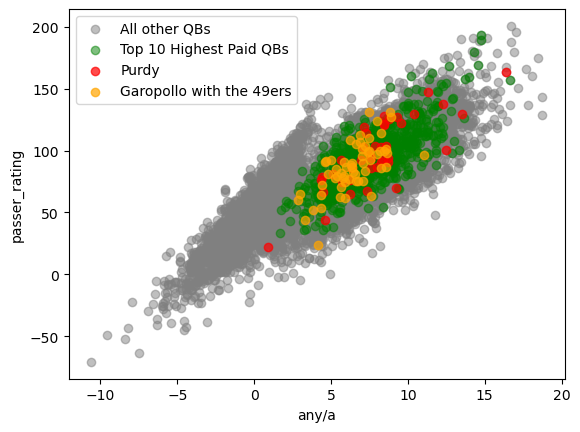

In [77]:
plot_qb_purdy_ten(x_label='any/a', y_label='passer_rating', include_garopollo=True)
#statistically significant on both ends: any/a and passer_rating

In [75]:
for i in qb_game_data.select_dtypes(include='number').columns:
    compare_stat(qb2_data = top_ten_data, stat_col = i)

air_yards
t_stat = -1.7339724482009993
pvalue = 0.08930410249019627

yards_after_catch
t_stat = 0.37385579499061783
pvalue = 0.7102660905370118

yards_gained
t_stat = 1.1809949266608444
pvalue = 0.24356521103298454

sack_yards
t_stat = 2.601101247968342
pvalue = 0.012247498956297297
The difference is statistically significant

touchdown
t_stat = -0.11498285049420968
pvalue = 0.9089627300105924

complete_pass
t_stat = -4.010791957656523
pvalue = 0.00019293718252819534
The difference is statistically significant

interception
t_stat = -0.19433652053152575
pvalue = 0.8467969387288619

pass_attempt
t_stat = -5.014261138388398
pvalue = 6.4404557518788785e-06
The difference is statistically significant

sack
t_stat = -1.406599507115986
pvalue = 0.16602443580616377

qb_epa
t_stat = 2.5068076316261956
pvalue = 0.015911667527914154
The difference is statistically significant

any/a
t_stat = 1.1580530994316396
pvalue = 0.25310196207447533

passer_rating
t_stat = 1.1752889390136096
pvalue = 0.246

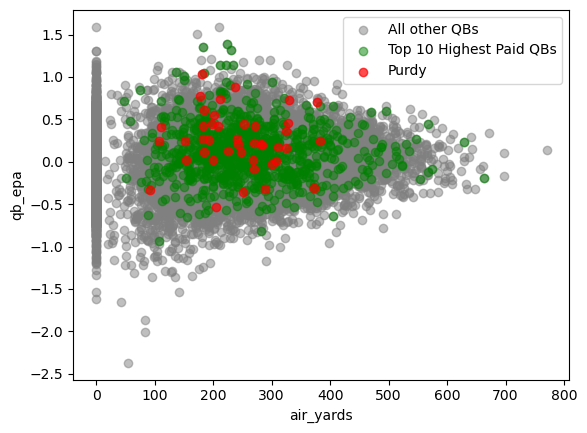

statistically significant:
top ten highest paid epa: 0.11631430162660313
purdy epa: 0.2521492690087716


In [81]:
plot_qb_purdy_ten(x_label='air_yards', y_label='qb_epa')
print("statistically significant:")
print(f"top ten highest paid epa: {top_ten_data['qb_epa'].mean()}")
print(f"purdy epa: {purdy_data['qb_epa'].mean()}")

In [76]:
for i in qb_game_data.select_dtypes(include='number').columns:
    compare_stat(qb2_data = qb_game_data, stat_col = i)

air_yards
t_stat = 4.043195289886925
pvalue = 0.00022053941094616578
The difference is statistically significant

yards_after_catch
t_stat = 6.094930373350464
pvalue = 3.0471987372240354e-07
The difference is statistically significant

yards_gained
t_stat = 3.477097059127143
pvalue = 0.0012052861668438682
The difference is statistically significant

sack_yards
t_stat = 2.944488811513605
pvalue = 0.005281096500778811
The difference is statistically significant

touchdown
t_stat = 1.1648564567356219
pvalue = 0.25076990881706435

complete_pass
t_stat = -0.34969141299769
pvalue = 0.7283296310784806

interception
t_stat = -1.5580419232058849
pvalue = 0.1268620506633111

pass_attempt
t_stat = -3.6397867713822865
pvalue = 0.0007461229942979396
The difference is statistically significant

sack
t_stat = -1.8246349494851708
pvalue = 0.0752729967569592

qb_epa
t_stat = 4.19622009618894
pvalue = 0.00014083788261777015
The difference is statistically significant

any/a
t_stat = 6.00653612635183
pva

In [82]:
print("statistically significant:")
print(f"top ten highest paid epa: {qb_game_data['qb_epa'].mean()}")
print(f"purdy epa: {purdy_data['qb_epa'].mean()}")
print(f"top ten highest paid any/a: {qb_game_data['any/a'].mean()}")
print(f"purdy any/a: {purdy_data['any/a'].mean()}")
print(f"top ten highest paid passer_rating: {qb_game_data['passer_rating'].mean()}")
print(f"purdy passer_rating: {purdy_data['passer_rating'].mean()}")

statistically significant:
top ten highest paid epa: 0.02899521030864541
purdy epa: 0.2521492690087716
top ten highest paid any/a: 5.438603624352326
purdy any/a: 7.943033110093436
top ten highest paid passer_rating: 77.37014090879867
purdy passer_rating: 98.24383512215383


<Axes: >

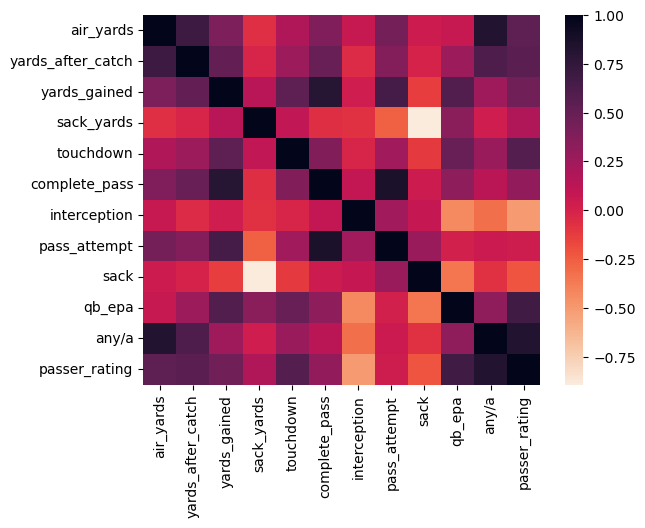

In [40]:
sns.heatmap(qb_game_data.select_dtypes(include='number').corr(), cmap='rocket_r')